Implement random data generator

In [1]:
import random
import numpy as np

def generateRandomData(num_points=10, dims=2, ranges=(-1,1), style='scatter', clusters=3, deviation=.2):
    if style == 'scatter':
        data = np.random.random((num_points, dims))*(ranges[1]-ranges[0])+ranges[0]
    if style == 'clustered':
        centers = np.random.random((clusters, dims))*(ranges[1]-ranges[0])+ranges[0]
        data = np.zeros((num_points, dims))
        for i in range(num_points):
            data[i,:] = np.random.normal(loc=centers[np.random.randint(clusters)],scale=deviation,size=dims)
    return data

Implement function used in multiple algorithms, and a simple exhaustiveSearch to use for correctness testing.

In [4]:
import sys
import copy

def computeScore(data, clusters):
    cluster_nums = set(clusters)
    score = 0
    for i in cluster_nums:
        if i != -1:
            cluster = data[clusters == i]
            mid = np.mean(cluster, 0)
            score += np.sum((cluster - mid)**2)
    #print((clusters,score))
    return score
            
def exhuastiveSearch(data,k):
    n = len(data)
    current_try = np.array(n*[0])
    best = (sys.float_info.max,None)
    
    done = False
    while not done:
        score = computeScore(data, current_try)
        if score < best[0]:
            best = (score, copy.copy(current_try))
        i = 0
        while True:
            if i == n:
                done = True
                break
            if current_try[i] == (k-1) or current_try[i] == i:
                current_try[i] = 0
                i += 1
            else:
                current_try[i] += 1
                break
        
    return best

Implement branch and bound algorithm

In [133]:
import queue
from itertools import combinations

def getIndexUnalloc(cluster):
    n = len(cluster)
    for i in range(n):
        if cluster[i] == -1:
            return i
    return -1

def scoreToInt(scoreStruct):
    score = 0
    for cluster in scoreStruct:
        if cluster[1] != 0:
            score += cluster[0]/cluster[1]
    return score
    
def calcEncapsulation(data):
    n,m = data.shape
    planes = {}
    #calculate hyperplanes
    for comb in combinations(range(n),m):
        #print(comb)
        #print(np.take(data, comb, axis=0))
        planes[comb] = np.matrix.dot(np.linalg.inv(np.take(data,comb,axis=0)),np.ones((m,1))).reshape((m))
    #print(planes)
    #distances from hyperplanes d = |w.x+b|/||w||
    sides = {}
    for plane in planes:
        sides[plane] = n*[0]
        for i in range(n):
            if not i in plane:
                dist = np.dot(planes[plane],data[i,:])-1
                if dist > 0:
                    sides[plane][i] = 1
                elif dist < 0:
                    sides[plane][i] = -1
    #print(sides)
    #turn into encapsulation data
    encaps = {}
    for encap in combinations(range(n),m+1):
        valid = n*[True]
        for i in encap:
            #print(i)
            valid[i] = False
        for i in range(len(encap)):
            lencap = list(encap)
            lencap.pop(i)
            plane = tuple(lencap)
            side = sides[plane][encap[i]]
            if side == 1:
                test = lambda x : x >= 0
            elif side == -1:
                test = lambda x : x <= 0
            else:
                test = lambda x : x == 0
            for j in range(n):
                if not test(sides[plane][j]):
                    #print(j)
                    valid[j] = False
        #print(valid)
        encaps[encap] = list(np.where(valid)[0])
    return encaps

def calcExtras(cluster, ind, new_cluster, encaps, m):
    res = set()
    elems = [ind]
    for i in range(len(cluster)):
        if cluster[i] == new_cluster:
            elems.append(i)
    for encap in sorted(combinations(sorted(elems), m+1)):
        if ind in encap:
            for point in encaps[encap]:
                if cluster[point] == -1:
                    res.add(point)
                elif cluster[point] != new_cluster:
                        return None
    return list(res)

def incrementScore(score, clusters, ind, new_cluster, dists, direction = 1):
    for i in range(len(clusters)):
        if clusters[i] == new_cluster:
            score[new_cluster][0] += direction*dists[i,ind]
    score[new_cluster][1] += direction*1


def addToCluster(data,cluster,score,inds,clust,recompute_score):
    clusterc = cluster.copy()
    if not recompute_score:
        scorec = copy.deepcopy(score)
    for ind in inds:
        clusterc[ind] = clust
        if not recompute_score:
            incrementScore(scorec, cluster, ind, clust, data)
    if recompute_score:
        scorec = computeScore(data,clusterc)
    return (clusterc, scorec)
    
def nearestMean(data, clusters):
    n,m = data.shape
    clusters = copy.deepcopy(clusters)
    cluster_nums = set(clusters)
    cluster_nums.discard(-1)
    cluster_nums = list(cluster_nums)
    k = len(cluster_nums)
    centers = k*[0]
    for i in range(k):
        centers[i] = np.mean(data[clusters == cluster_nums[i]],0)
    for i in range(n):
        if clusters[i] == -1:
            clusters[i] = cluster_nums[np.argmin(np.sum((centers - data[i])**2,1))]
    return computeScore(data, clusters)
    
def branchNBound(data,k,recompute_score = True, capFunc = None, encapsulate = False):
    n,m = data.shape
    if encapsulate == True:
        encaps = calcEncapsulation(data)
    if recompute_score == False:
        if not capFunc is None:
            data_store = copy.deepcopy(data)
        data = np.sum((data.reshape((n,m,1))-np.transpose(data).reshape((1,m,n)))**2,axis=1)
    q = queue.Queue()
    #stack = []
    inital = np.array(n*[-1])
    if recompute_score:
        score = 0
    else:
        score = k*[0]
        for i in range(k):
            score[i] = [0,0]
    q.put((inital,score))
    cap = float('inf')
    best = (inital,float('inf'))
    while not q.empty():
        inp = q.get()
        #print(inp)
        cluster = inp[0]
        score = inp[1]
        ind = getIndexUnalloc(cluster)
        if ind != -1:
            for i in range(k):
                #print(i)
                clust_first = (i not in cluster)
                if encapsulate:
                    inds = calcExtras(cluster, ind, i, encaps, m)
                    if inds == None:
                        continue
                else:
                    inds = [ind]
                ret = addToCluster(data,cluster,score,[ind],i,recompute_score)
                if not capFunc is None:
                    cap_test = capFunc(data_store, ret[0])
                    if cap_test < cap:
                        cap = cap_test
                if recompute_score:
                    if (cap + .00001) >= ret[1]:
                        q.put(ret)
                else:
                    if (cap + .00001) >= scoreToInt(ret[1]):
                        q.put(ret)
                if clust_first:
                    break
        else:
            if recompute_score:
                scoref = score
            else:
                scoref = scoreToInt(score)
            if scoref < best[1]:
                best = (cluster,scoref)
                #print(best)
    return best[1], best[0]
            

Implement H-Means

In [6]:
def hMeans(data, k):
    n, d = data.shape
    centers = data[np.random.randint(n, size=k)]
    clusters = np.zeros(n)
    clustersold = np.zeros(n)
    while True:
        valid = False
        while not valid:
            for i in range(n):
                clustersold[i] = clusters[i]
                clusters[i] = np.argmin(np.sum((centers - data[i])**2,1))
            missing = False
            for i in range(k):
                if i not in clusters:
                    centers[i] = data[np.random.randint(n)]
                    missing = True
            if not missing:
                valid = True
        if np.array_equal(clusters, clustersold):
            return computeScore(data, clusters), clusters
        for i in range(k):
            centers[i] = np.mean(data[clusters == i],0)
        
            

Implement K-Means

In [90]:
def kMeans(data, k):
    n,m = data.shape
    clusters = np.random.randint(k, size=n)
    clusters_try = clusters.copy()
    score = computeScore(data, clusters)
    while True:
        old_score = score
        for i in range(n):
            for j in range(k):
                clusters_try[i] = j
                score_try = computeScore(data, clusters_try) # change to compute score diffrence
                if score_try < score:
                    score = score_try
                    clusters[i] = j
                else:
                    clusters_try[i] = clusters[i]
        if score == old_score:
            break
    return score, clusters

Running of tests and generation of plots of test data.

In [8]:
import time
import pickle

def record(methods, data_method, increments, num, name, notes):
    time_dat = []
    score_dat = []
    increments = list(increments)
    m = len(methods)
    for _ in range(m):
        time_dat.append([])
        score_dat.append([])
        
    for i in range(len(increments)):
        scores = []
        times = []
        for j in range(m):
            scores.append([])
            times.append([])
        for n in range(num):
            data = data_method(increments[i])
            for j in range(m):
                t = time.process_time()
                res = methods[j](data)
                taken = time.process_time()-t
                times[j].append(taken)
                scores[j].append(res[0])
        for j in range(m):
            time_dat[j].append(times[j])
            score_dat[j].append(scores[j])
    f = open(name, 'wb')
    pickle.dump((increments, time_dat, score_dat, notes), f)
    f.close()

In [9]:
def formatData(data, ind):
    indices = np.array(data[0])
    values = np.array(data[ind])
    m = len(values)
    vpi = len(values[0][0])
    res = (2*m+1)*[0]
    res[0] = indices
    for i in range(m):
        res[2*i+1] = np.mean(values[i,:,:],axis=1)
        res[2*i+2] = np.std(values[i,:,:],axis=1)
    return res

In [10]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 2),
      lambda data : branchNBound(data, 2, recompute_score=False)]
record(met, dat, range(4,16,1), 10, 'test1', 'branchNbound with/without partial score computation, k=2, m=2')

In [11]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 3),
      lambda data : branchNBound(data, 3, recompute_score=False)]
record(met, dat, range(4,13,1), 10, 'test2', 'branchNbound with/without partial score computation, k=3, m=2')

In [12]:
dat = lambda inc : generateRandomData(num_points=inc,dims=5)
met = [lambda data : branchNBound(data, 3),
      lambda data : branchNBound(data, 3, recompute_score=False)]
record(met, dat, range(4,13,1), 10, 'test3', 'branchNbound with/without partial score computation, k=3, m=5')

In [13]:
f = open('test1', 'rb')
data1 = pickle.load(f)
f.close()
f = open('test2', 'rb')
data2 = pickle.load(f)
f.close()
f = open('test3', 'rb')
data3 = pickle.load(f)
f.close()

In [14]:
import matplotlib.pyplot as plt

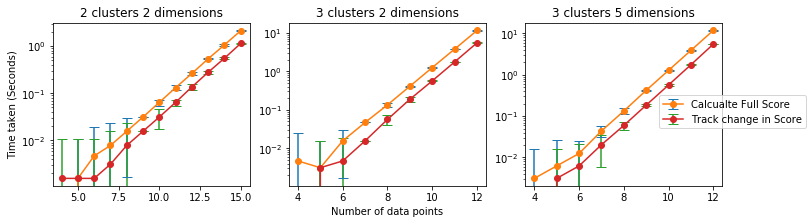

In [159]:
fig, _ = plt.subplots(1,3,figsize=(12, 3))
plt.subplot(1,3,1)
x, y1, y1e, y2, y2e = formatData(data1, 1)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Calcualte Full Score')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='Track change in Score')
#ax1.yscale('log')
plt.title('2 clusters 2 dimensions')
fig.legend(loc='right')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data2, 1)
plt.subplot(1,3,2)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Calcualte Full Score')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='Track change in Score')
plt.title('3 clusters 2 dimensions')
plt.xlabel('Number of data points')
#plt.legend()
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data3, 1)
plt.subplot(1,3,3)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Calcualte Full Score')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='Track change in Score')
plt.title('3 clusters 5 dimensions')
plt.yscale('log')
plt.savefig('fig1')

In [16]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 2, recompute_score=False),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,16,1), 10, 'test4', 'branchNbound with/without convex hull bounding, k=2, m=2')

In [18]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 3, recompute_score=False),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,14,1), 10, 'test5', 'branchNbound with/without convex hull bounding, k=3, m=2')

In [19]:
dat = lambda inc : generateRandomData(num_points=inc,dims=3)
met = [lambda data : branchNBound(data, 2, recompute_score=False),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,16,1), 10, 'test6', 'branchNbound with/without convex hull bounding, k=2, m=3')

In [20]:
dat = lambda inc : generateRandomData(num_points=inc,dims=3)
met = [lambda data : branchNBound(data, 3, recompute_score=False),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,14,1), 10, 'test7', 'branchNbound with/without convex hull bounding, k=3, m=3')

In [25]:
dat = lambda inc : generateRandomData(num_points=inc,dims=4)
met = [lambda data : branchNBound(data, 2, recompute_score=False),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,16,1), 10, 'test8', 'branchNbound with/without convex hull bounding, k=2, m=4')

In [26]:
dat = lambda inc : generateRandomData(num_points=inc,dims=4)
met = [lambda data : branchNBound(data, 3, recompute_score=False),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True)]
record(met, dat, range(4,14,1), 10, 'test9', 'branchNbound with/without convex hull bounding, k=3, m=4')

In [29]:
f = open('test4', 'rb')
data4 = pickle.load(f)
f.close()
f = open('test5', 'rb')
data5 = pickle.load(f)
f.close()
f = open('test6', 'rb')
data6 = pickle.load(f)
f.close()
f = open('test7', 'rb')
data7 = pickle.load(f)
f.close()
f = open('test8', 'rb')
data8 = pickle.load(f)
f.close()
f = open('test9', 'rb')
data9 = pickle.load(f)
f.close()

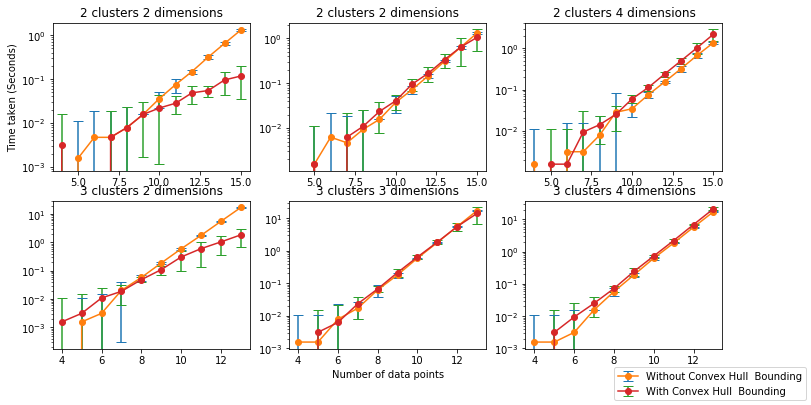

In [160]:
fig, _ = plt.subplots(2,3,figsize=(12, 6))
plt.subplot(2,3,1)
x, y1, y1e, y2, y2e = formatData(data4, 1)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
fig.legend(loc='lower right')
x, y1, y1e, y2, y2e = formatData(data6, 1)
plt.subplot(2,3,2)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data8, 1)
plt.subplot(2,3,3)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('2 clusters 4 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data5, 1)
plt.subplot(2,3,4)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('3 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data7, 1)
plt.subplot(2,3,5)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('3 clusters 3 dimensions')
plt.yscale('log')
plt.xlabel('Number of data points')
x, y1, y1e, y2, y2e = formatData(data9, 1)
plt.subplot(2,3,6)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Convex Hull  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Convex Hull  Bounding')
plt.title('3 clusters 4 dimensions')
plt.yscale('log')
plt.savefig('fig2')

In [135]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test10', 'branchNbound with/without min-max bounding, k=2, m=2')

In [136]:
dat = lambda inc : generateRandomData(num_points=inc,dims=3)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test11', 'branchNbound with/without min-max bounding, k=2, m=3')

In [137]:
dat = lambda inc : generateRandomData(num_points=inc,dims=4)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test12', 'branchNbound with/without min-max bounding, k=2, m=4')

In [138]:
dat = lambda inc : generateRandomData(num_points=inc)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test13', 'branchNbound with/without min-max bounding, k=3, m=2')

In [139]:
dat = lambda inc : generateRandomData(num_points=inc,dims=3)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test14', 'branchNbound with/without min-max bounding, k=3, m=3')

In [140]:
dat = lambda inc : generateRandomData(num_points=inc,dims=4)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True),
      lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test15', 'branchNbound with/without min-max bounding, k=3, m=4')

In [178]:
f = open('test10', 'rb')
data10 = pickle.load(f)
f.close()
f = open('test11', 'rb')
data11 = pickle.load(f)
f.close()
f = open('test12', 'rb')
data12 = pickle.load(f)
f.close()
f = open('test13', 'rb')
data13 = pickle.load(f)
f.close()
f = open('test14', 'rb')
data14 = pickle.load(f)
f.close()
f = open('test15', 'rb')
data15 = pickle.load(f)
f.close()

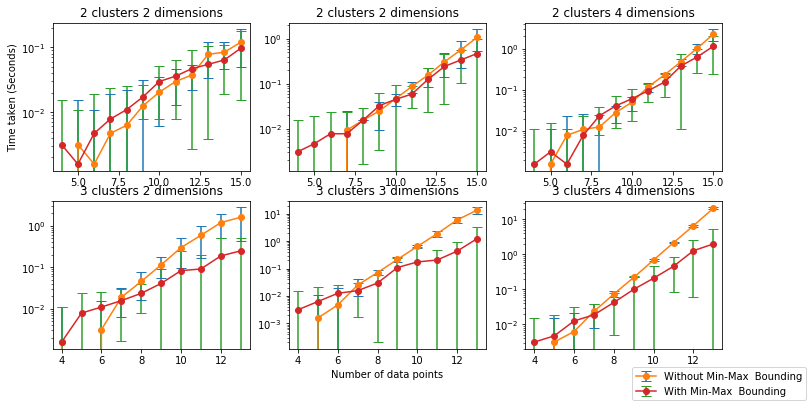

In [185]:
fig, _ = plt.subplots(2,3,figsize=(12, 6))
plt.subplot(2,3,1)
x, y1, y1e, y2, y2e = formatData(data10, 1)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max  Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max  Bounding')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
fig.legend(loc='lower right')
x, y1, y1e, y2, y2e = formatData(data11, 1)
plt.subplot(2,3,2)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max Bounding')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data12, 1)
plt.subplot(2,3,3)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max Bounding')
plt.title('2 clusters 4 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data13, 1)
plt.subplot(2,3,4)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max Bounding')
plt.title('3 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData(data14, 1)
plt.subplot(2,3,5)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max Bounding')
plt.title('3 clusters 3 dimensions')
plt.yscale('log')
plt.xlabel('Number of data points')
x, y1, y1e, y2, y2e = formatData(data15, 1)
plt.subplot(2,3,6)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', fmt="o-", capsize=5, label='Without Min-Max Bounding')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', fmt="o-", capsize=5, label='With Min-Max Bounding')
plt.title('3 clusters 4 dimensions')
plt.yscale('log')
plt.savefig('fig3')

In [144]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=2)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test16', 'branchNbound with uniform vs clustered data, k=2, m=2')

In [145]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=2, style='clustered')
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test17', 'branchNbound with uniform vs clustered data, k=2, m=2')

In [146]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=3)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test18', 'branchNbound with uniform vs clustered data, k=2, m=3')

In [147]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=3, style='clustered')
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test19', 'branchNbound with uniform vs clustered data, k=2, m=3')

In [148]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=4)
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test20', 'branchNbound with uniform vs clustered data, k=2, m=4')

In [149]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=2, dims=4, style='clustered')
met = [lambda data : branchNBound(data, 2, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,16,1), 10, 'test21', 'branchNbound with uniform vs clustered data, k=2, m=4')

In [150]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=2)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test22', 'branchNbound with uniform vs clustered data, k=3, m=2')

In [151]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=2, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test23', 'branchNbound with uniform vs clustered data, k=3, m=2')

In [152]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=3)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test24', 'branchNbound with uniform vs clustered data, k=3, m=3')

In [153]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=3, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test25', 'branchNbound with uniform vs clustered data, k=3, m=3')

In [154]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=4)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test26', 'branchNbound with uniform vs clustered data, k=3, m=4')

In [155]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=4, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean)]
record(met, dat, range(4,14,1), 10, 'test27', 'branchNbound with uniform vs clustered data, k=3, m=4')

In [156]:
def formatData2(data1, data2, ind):
    indices = np.array(data1[0])
    values1 = np.array(data1[ind])
    values2 = np.array(data2[ind])
    m = len(values1)
    vpi = len(values1[0][0])
    res = (4*m+1)*[0]
    res[0] = indices
    for i in range(m):
        res[4*i+1] = np.mean(values1[i,:,:],axis=1)
        res[4*i+2] = np.std(values1[i,:,:],axis=1)
        res[4*i+3] = np.mean(values2[i,:,:],axis=1)
        res[4*i+4] = np.std(values2[i,:,:],axis=1)
    return res

In [176]:
f = open('test16', 'rb')
data16 = pickle.load(f)
f.close()
f = open('test17', 'rb')
data17 = pickle.load(f)
f.close()
f = open('test18', 'rb')
data18 = pickle.load(f)
f.close()
f = open('test19', 'rb')
data19 = pickle.load(f)
f.close()
f = open('test20', 'rb')
data20 = pickle.load(f)
f.close()
f = open('test21', 'rb')
data21 = pickle.load(f)
f.close()
f = open('test22', 'rb')
data22 = pickle.load(f)
f.close()
f = open('test23', 'rb')
data23 = pickle.load(f)
f.close()
f = open('test24', 'rb')
data24 = pickle.load(f)
f.close()
f = open('test25', 'rb')
data25 = pickle.load(f)
f.close()
f = open('test26', 'rb')
data26 = pickle.load(f)
f.close()
f = open('test27', 'rb')
data27 = pickle.load(f)
f.close()

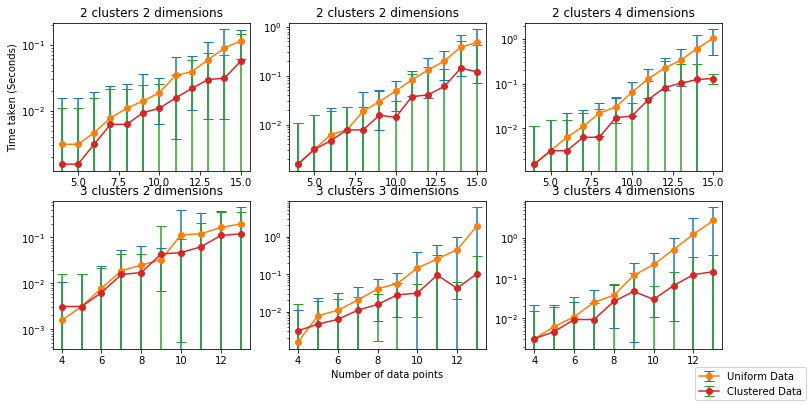

In [177]:
fig, _ = plt.subplots(2,3,figsize=(12, 6))
plt.subplot(2,3,1)
x, y1, y1e, y2, y2e = formatData2(data16, data17, 1)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
fig.legend(loc='lower right')
x, y1, y1e, y2, y2e = formatData2(data18, data19, 1)
plt.subplot(2,3,2)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('2 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData2(data20, data21, 1)
plt.subplot(2,3,3)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1',  capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('2 clusters 4 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData2(data22, data23, 1)
plt.subplot(2,3,4)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('3 clusters 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e = formatData2(data24, data25, 1)
plt.subplot(2,3,5)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('3 clusters 3 dimensions')
plt.yscale('log')
plt.xlabel('Number of data points')
x, y1, y1e, y2, y2e = formatData2(data26, data27, 1)
plt.subplot(2,3,6)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Uniform Data')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='Clustered Data')
plt.title('3 clusters 4 dimensions')
plt.yscale('log')
plt.savefig('fig4')

In [166]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=2)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test28', 'branchNbound vs hMeans vs kMeans, k=3, m=2')

In [167]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=3)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test29', 'branchNbound vs hMeans vs kMeans, k=3, m=3')

In [168]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=4)
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test30', 'branchNbound vs hMeans vs kMeans, k=3, m=4')

In [169]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=2, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test31', 'branchNbound vs hMeans vs kMeans, k=3, m=2')

In [170]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=3, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test32', 'branchNbound vs hMeans vs kMeans, k=3, m=3')

In [171]:
dat = lambda inc : generateRandomData(num_points=inc, clusters=3, dims=4, style='clustered')
met = [lambda data : branchNBound(data, 3, recompute_score=False, encapsulate=True, capFunc=nearestMean),
      lambda data : kMeans(data, 3),
      lambda data : hMeans(data, 3)]
record(met, dat, range(4,15,1), 10, 'test33', 'branchNbound vs hMeans vs kMeans, k=3, m=4')

In [173]:
f = open('test28', 'rb')
data28 = pickle.load(f)
f.close()
f = open('test29', 'rb')
data29 = pickle.load(f)
f.close()
f = open('test30', 'rb')
data30 = pickle.load(f)
f.close()
f = open('test31', 'rb')
data31 = pickle.load(f)
f.close()
f = open('test32', 'rb')
data32 = pickle.load(f)
f.close()
f = open('test33', 'rb')
data33 = pickle.load(f)
f.close()

In [174]:
def formatDataAccuracy(data, base_ind):
    indices = np.array(data[0])
    values = np.array(data[2])
    m = len(values)
    vpi = len(values[0][0])
    res = (2*m+1)*[0]
    res[0] = indices
    for i in range(m):
        res[2*i+1] = np.mean(values[i,:,:]/values[base_ind,:,:],axis=1)
        res[2*i+2] = np.std(values[i,:,:]/values[base_ind,:,:],axis=1)
    return res

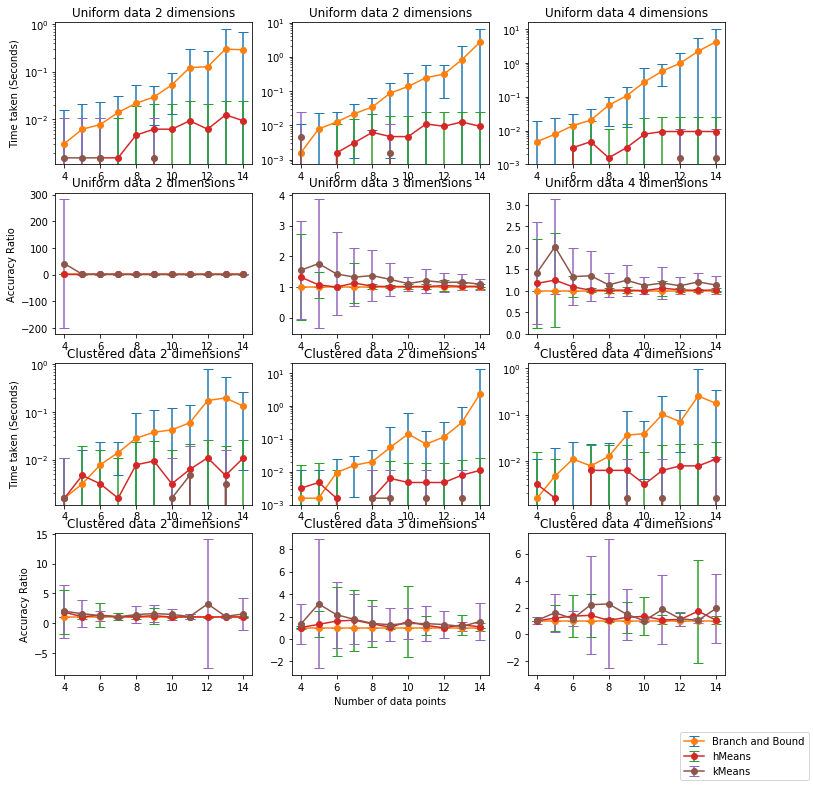

In [184]:
fig, _ = plt.subplots(4,3,figsize=(12, 12))
plt.subplot(4,3,1)
x, y1, y1e, y2, y2e, y3, y3e = formatData(data28, 1)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 2 dimensions')
plt.yscale('log')
fig.legend(loc='lower right')
x, y1, y1e, y2, y2e, y3, y3e = formatData(data29, 1)
plt.subplot(4,3,2)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatData(data30, 1)
plt.subplot(4,3,3)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 4 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data28, 0)
plt.subplot(4,3,4)
plt.ylabel('Accuracy Ratio')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 2 dimensions')
#plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data29, 0)
plt.subplot(4,3,5)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 3 dimensions')
#plt.yscale('log')
#plt.xlabel('Number of data points')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data30, 0)
plt.subplot(4,3,6)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Uniform data 4 dimensions')
#plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatData(data31, 1)
plt.subplot(4,3,7)
plt.ylabel('Time taken (Seconds)')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 2 dimensions')
plt.yscale('log')
#fig.legend(loc='lower right')
x, y1, y1e, y2, y2e, y3, y3e = formatData(data32, 1)
plt.subplot(4,3,8)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 2 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatData(data33, 1)
plt.subplot(4,3,9)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 4 dimensions')
plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data31, 0)
plt.subplot(4,3,10)
plt.ylabel('Accuracy Ratio')
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 2 dimensions')
#plt.yscale('log')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data32, 0)
plt.subplot(4,3,11)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 3 dimensions')
#plt.yscale('log')
plt.xlabel('Number of data points')
x, y1, y1e, y2, y2e, y3, y3e = formatDataAccuracy(data33, 0)
plt.subplot(4,3,12)
plt.errorbar(x,y1,yerr=y1e*2, ecolor='C0', color='C1', capsize=5, fmt="o-", label='Branch and Bound')
plt.errorbar(x,y2,yerr=y2e*2, ecolor='C2', color='C3', capsize=5, fmt="o-", label='hMeans')
plt.errorbar(x,y3,yerr=y3e*2, ecolor='C4', color='C5', capsize=5, fmt="o-", label='kMeans')
plt.title('Clustered data 4 dimensions')
#plt.yscale('log')
plt.savefig('fig5')